/tmp/ipython-input-5-3442773573.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed


Annualized Volatility:
 Ticker
AAPL    0.284662
AMZN    0.327859
DIS     0.278448
TSLA    0.571629
dtype: float64
Volatility-Weighted Weights:
 Ticker
AAPL    0.295112
AMZN    0.256230
DIS     0.301698
TSLA    0.146961
dtype: float64


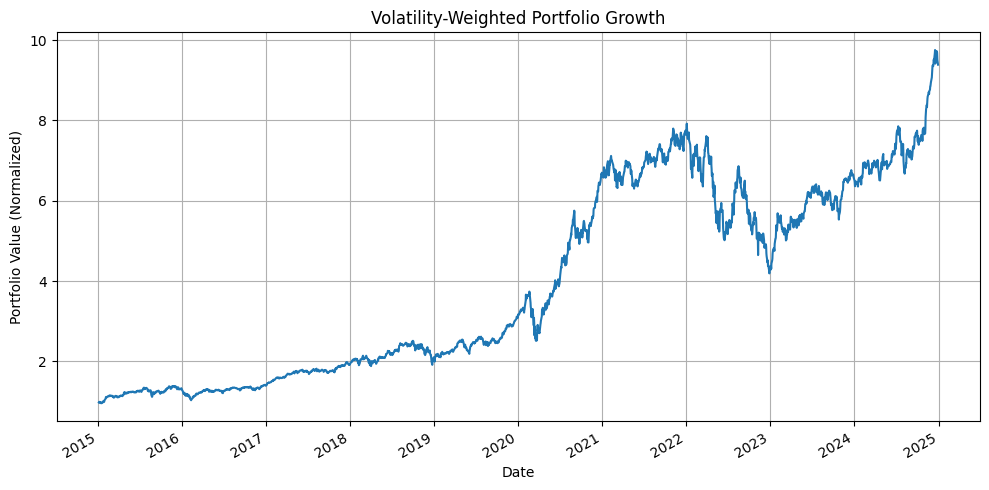

,Volatility,Weight (Inv Vol)
Ticker,,
AAPL,0.284662,0.295112
AMZN,0.327859,0.256230
DIS,0.278448,0.301698
TSLA,0.571629,0.146961


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define tickers and load data
tickers = ['AAPL', 'TSLA', 'DIS', 'AMZN']
start_date = '2015-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()

# Use annualized standard deviation (volatility)
volatility = returns.std() * np.sqrt(252)
print("Annualized Volatility:\n", volatility)

#get the normalised volatility matrix
inv_vol = 1 / volatility
vol_weights = inv_vol / inv_vol.sum()
print("Volatility-Weighted Weights:\n", vol_weights)

# Daily weighted returns
portfolio_returns = (returns * vol_weights).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

#plot the cumulative return
cumulative_returns.plot(figsize=(10, 5), title="Volatility-Weighted Portfolio Growth")
plt.ylabel("Portfolio Value (Normalized)")
plt.grid(True)
plt.tight_layout()
plt.show()

pd.DataFrame({
    'Volatility': volatility,
    'Weight (Inv Vol)': vol_weights
})


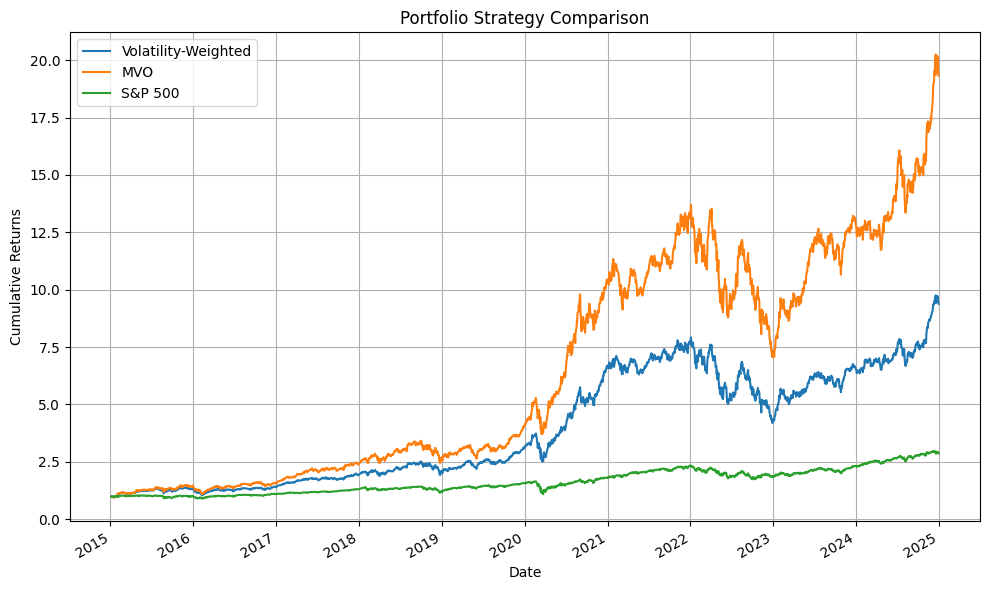

In [9]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

from scipy.optimize import minimize

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    p_return = np.dot(weights, mean_returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))
initial_guess = len(tickers) * [1. / len(tickers)]

opt_result = minimize(
    negative_sharpe_ratio,
    initial_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

mvo_weights = opt_result.x

mvo_returns = (returns * mvo_weights).sum(axis=1)
mvo_cum_returns = (1 + mvo_returns).cumprod()

comparison_df = pd.DataFrame({
    'Volatility-Weighted': cumulative_returns, # Use the cumulative returns from the first cell
    'MVO': mvo_cum_returns,
    'S&P 500': benchmark_cum.iloc[:, 0] # Extract the single column from the DataFrame
})

comparison_df.dropna().plot(figsize=(10, 6), title="Portfolio Strategy Comparison")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.tight_layout()
plt.show()